# HRS Spectrometer Neutrol network Model

In [21]:
import  pandas as pd
import numpy as np
import sklearn
import math
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import *
import math

## Load the Training dataset
- Merge Multi dataset
- randomize the order of the dataset
- [ftp data server](http://localhost/Data/spectro_nn/)

In [22]:
# files = ["../dataGenerator/result/PRex_DataSet_2239.csv",
#          "../dataGenerator/result/PRex_DataSet_2240.csv",
#          "../dataGenerator/result/PRex_DataSet_2241.csv",
#          "../dataGenerator/result/PRex_DataSet_2244.csv",
#          "../dataGenerator/result/PRex_DataSet_2245.csv",
#          "../dataGenerator/result/PRex_DataSet_2256.csv",
#          "../dataGenerator/result/PRex_DataSet_2257.csv"
#          ]

# large data set with all the features 
files = ["../dataGenerator/result/PRex_DataSet_Full_2239.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2240.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2241.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2244.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2245.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2256.csv",
         "../dataGenerator/result/PRex_DataSet_Full_2257.csv"
         ]
li = []
for filename in files:
    print("Loading file {}".format(filename))
    df = pd.read_csv(filename)
    li.append(df)
data = pd.concat(li)
data.sample(frac=1) # sample the data with fraction 1. rearrange the data in random order
data.head()

Loading file ../dataGenerator/result/PRex_DataSet_Full_2239.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2240.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2241.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2244.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2245.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2256.csv
Loading file ../dataGenerator/result/PRex_DataSet_Full_2257.csv


,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,x0th0y0ph0,x0th0y0ph1,x0th0y0ph2,...,x1th1y0ph1,x1th1y1ph0,x1th2y0ph0,x2th0y0ph0,x2th0y0ph1,x2th0y1ph0,x2th1y0ph0,x3th0y0ph0,targCalTh,targCalPh
0,0,2239,136,3,5,0.003794,-0.000501,1,-0.001618,0.000003,...,1.296960e-08,-8.871840e-08,-4.421870e-09,0.000211,-3.417730e-07,2.337890e-06,1.165240e-07,-3.070630e-06,-0.000817,-0.010117
1,1,2239,130,4,4,0.003794,-0.000501,1,-0.009000,0.000081,...,-1.656010e-06,1.566530e-06,-1.234510e-06,0.000752,-6.769360e-06,6.403600e-06,-5.046360e-06,-2.062830e-05,0.019571,-0.012569
2,2,2239,179,4,11,0.003794,-0.000501,1,0.014969,0.000224,...,1.342550e-06,-1.314770e-06,-5.773750e-07,0.000194,2.905640e-06,-2.845500e-06,-1.249590e-06,-2.704440e-06,0.012775,0.014835
3,3,2239,142,2,6,0.003794,-0.000501,1,0.001385,0.000002,...,-8.322590e-08,-1.815250e-07,-3.361390e-07,0.000115,1.597740e-07,3.484850e-07,6.453060e-07,-1.238830e-06,-0.014409,-0.003863
4,4,2239,127,1,4,0.003794,-0.000501,1,-0.004135,0.000017,...,5.811250e-08,-1.701580e-07,-9.063730e-08,0.000005,-1.963540e-08,5.749420e-08,3.062510e-08,-1.034780e-08,-0.021206,-0.012569


In [23]:
# print(data[data.runID.eq(2240)])

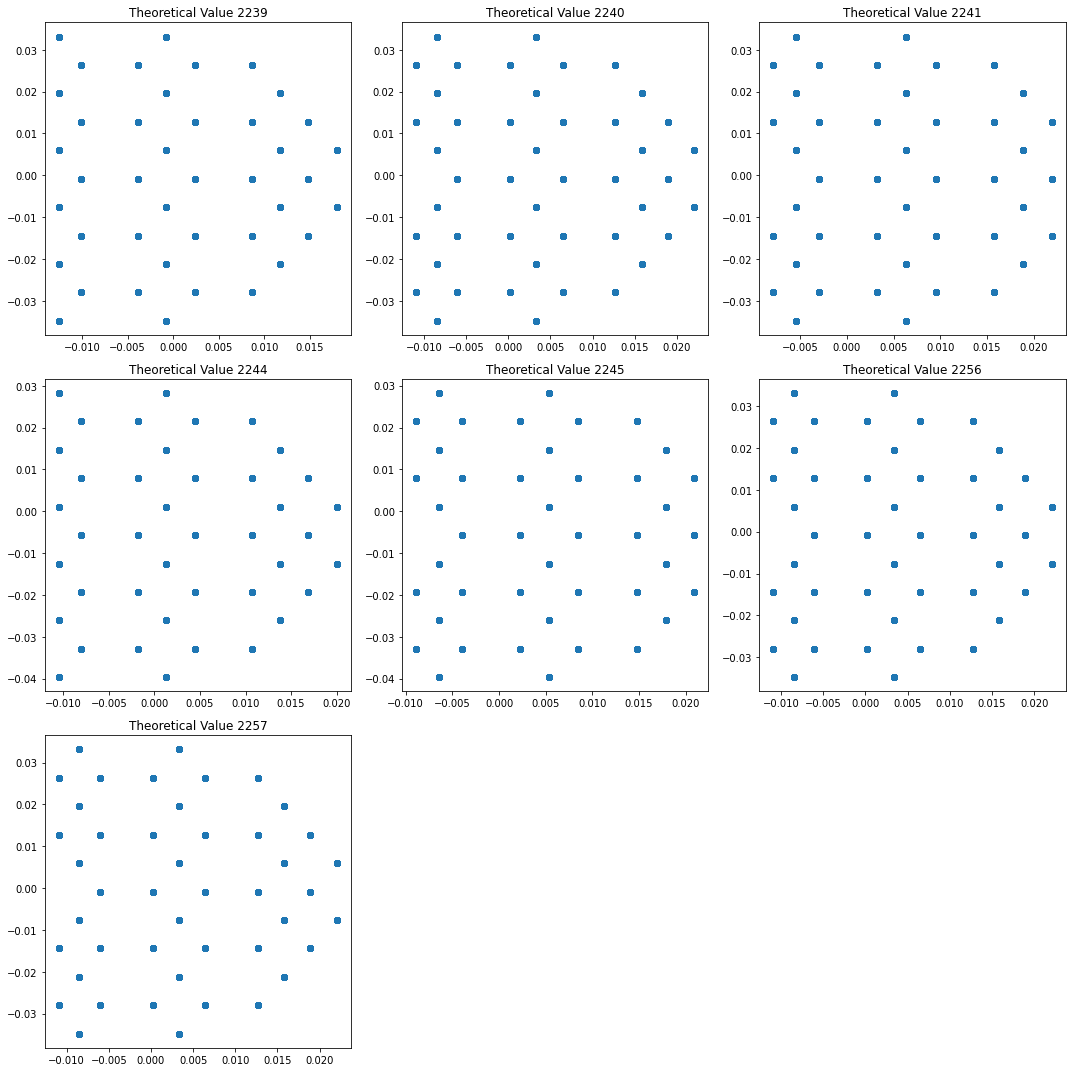

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(data[data.runID.eq(2239)]["targCalPh"],data[data.runID.eq(2239)]["targCalTh"])
ax0.set_title('Theoretical Value 2239')

ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(data[data.runID.eq(2240)]["targCalPh"],data[data.runID.eq(2240)]["targCalTh"])
ax1.set_title('Theoretical Value 2240')

ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(data[data.runID.eq(2241)]["targCalPh"],data[data.runID.eq(2241)]["targCalTh"])
ax2.set_title('Theoretical Value 2241')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(data[data.runID.eq(2244)]["targCalPh"],data[data.runID.eq(2244)]["targCalTh"])
ax3.set_title('Theoretical Value 2244')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(data[data.runID.eq(2245)]["targCalPh"],data[data.runID.eq(2245)]["targCalTh"])
ax4.set_title('Theoretical Value 2245')

ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(data[data.runID.eq(2256)]["targCalPh"],data[data.runID.eq(2256)]["targCalTh"])
ax5.set_title('Theoretical Value 2256')

ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(data[data.runID.eq(2257)]["targCalPh"],data[data.runID.eq(2257)]["targCalTh"])
ax6.set_title('Theoretical Value 2257')

plt.tight_layout()
plt.show()
# x = data[data.runID.eq(2241)]["targCalPh"]
# y = data[data.runID.eq(2241)]["targCalTh"]
# plt.scatter(x,y)
# plt.show()

# New Function Used for Train the X, and Y model seperately

## Prepare the Data

In [25]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

### 1. prepare the training data

(221493, 44)

In [26]:
train_X, test_X, train_y, test_y = train_test_split(
    data.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data[['targCalTh','targCalPh']],
    test_size=0.2,
    random_state=0)

n_feature = train_X.shape[1]
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((177194, 35), (177194, 2), (44299, 35), (44299, 2))

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptNet(nn.Module):
    def __init__(self):
        super(OptNet,self).__init__()
        #TODO model, need to auto adapt to the training dataset
        self.fc1 = nn.Linear(n_feature, n_feature)  # 6*6 from image dimension
        # self.fc2 = nn.Linear(2*n_feature, n_feature)
        # self.fc3 = nn.Linear(n_feature, n_feature//2)
        self.output = nn.Linear(n_feature, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        # x = F.sigmoid(self.fc3(x))
        x = self.output(x)
        return x



## Training on the $\theta_{targ}$

### 1. train the $\theta_{targ}$ model

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_trainTh = torch.tensor(train_X.to_numpy()).float().to(device)
y_trainTh = torch.tensor(train_y['targCalTh'].to_numpy()).float().to(device)
X_testTh  = torch.tensor(test_X.to_numpy()).float().to(device)
y_testTh  = torch.tensor(test_y['targCalTh'].to_numpy()).float().to(device)



In [29]:
import torch.optim as optim
thetaOptnet = OptNet()
thetaOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(thetaOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
for epoch in range(20):
    running_loss = 0.0
    for i in range(len(y_trainTh)):
        inputs = X_trainTh[i]#.to(device)
        labels = y_trainTh[i]#.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = thetaOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 2000))
            running_loss = 0.0
        torch.save(thetaOptnet.state_dict(), "./model/Theta_net_ep{}.pth".format(epoch))
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
theta_model_PATH = './model/Theta_net.pth'
torch.save(thetaOptnet.state_dict(), theta_model_PATH)

/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  2000, 0.010000] loss: 0.000377262
[1,  4000, 0.010000] loss: 0.000144556
[1,  6000, 0.010000] loss: 0.000125074
[1,  8000, 0.010000] loss: 0.000111740
[1, 10000, 0.010000] loss: 0.000083530
[1, 12000, 0.010000] loss: 0.000062166
[1, 14000, 0.010000] loss: 0.000062472
[1, 16000, 0.010000] loss: 0.000046526
[1, 18000, 0.010000] loss: 0.000043675
[1, 20000, 0.010000] loss: 0.000038058
[1, 22000, 0.010000] loss: 0.000038413
[1, 24000, 0.010000] loss: 0.000031240
[1, 26000, 0.010000] loss: 0.000031984
[1, 28000, 0.010000] loss: 0.000030479
[1, 30000, 0.010000] loss: 0.000025665
[1, 32000, 0.010000] loss: 0.000026848
[1, 34000, 0.010000] loss: 0.000027039
[1, 36000, 0.010000] loss: 0.000023877
[1, 38000, 0.010000] loss: 0.000021135
[1, 40000, 0.010000] loss: 0.000020983
[1, 42000, 0.010000] loss: 0.000019184
[1, 44000, 0.010000] loss: 0.000021236
[1, 46000, 0.010000] loss: 0.000020344
[1, 48000, 0.010000] loss: 0.000017206
[1, 50000, 0.010000] loss: 0.000017815
[1, 52000, 0.010000] loss

KeyboardInterrupt: 

## Training on the $\phi_{targ}$

### 2. train the $\phi_{targ}$ model

In [ ]:
X_trainPh = torch.tensor(train_X.to_numpy()).float()
y_trainPh = torch.tensor(train_y['targCalPh'].to_numpy()).float()
X_testPh  = torch.tensor(test_X.to_numpy()).float()
y_testPh  = torch.tensor(test_y['targCalPh'].to_numpy()).float()

In [ ]:
phiOptnet = OptNet()
phiOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(phiOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
for epoch in range(20):
    running_loss = 0.0
    for i in range(len(y_trainPh)):
        inputs = X_trainPh[i].to(device)
        labels = y_trainPh[i].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs =  phiOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 2000))
            running_loss = 0.0
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
phi_model_PATH = './model/Phi_net.pth'
torch.save(phiOptnet.state_dict(), phi_model_PATH)


## Test the Training model

### 1. Seperate Test on the $\theta$ and $\phi$ on the test dataset
-

In [ ]:
phi_model_PATH = './model/Phi_net.pth'
theta_model_PATH = './model/Theta_net.pth'

testNet_theta = OptNet()
testNet_theta.to(device)
testNet_theta.load_state_dict(torch.load(theta_model_PATH))

test_loss = 0
mseArr = []

with torch.no_grad():
    for i in range(len(y_testTh)):
        positions = X_testTh[i]
        labels = y_testTh[i]

        outputs = testNet_theta(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

In [ ]:
testNet_phi = OptNet()
testNet_phi.to(device)
testNet_phi.load_state_dict(torch.load(phi_model_PATH))

test_loss = 0
mseArr = []
with torch.no_grad():
    for i in range(len(y_testPh)):
        positions = X_testPh[i].to(device)
        labels = y_testPh[i].to(device)
        outputs = testNet_phi(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

### 2.2D histogram distribution test (Include all the training and test dataset)

In [ ]:
def predictor(model_path,x_test):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = OptNet()
    net.load_state_dict(torch.load(model_path))
    net.to(device)
    res = torch.empty(0)
    with torch.no_grad():
        for i in range(len(x_test)):
            positions = x_test[i].to(device)
            outputs = net(positions).cpu()
            res = torch.cat((res,outputs))
    return res

In [ ]:
alldatadf = data[data.runID.eq(2245)]
# get the theta and phi dimension and get the predictions
alldata = alldatadf.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1)

alldatatensor = torch.tensor(alldata.to_numpy()).float()

theta = predictor(theta_model_PATH,alldatatensor)
phi   = predictor(phi_model_PATH,alldatatensor)

alldatadf['predicPh'] =phi.numpy()
alldatadf['predicTh'] =theta.numpy()
alldatadf['residuTh'] = alldatadf['predicTh'] -alldatadf['targCalTh']
alldatadf['residuPh'] = alldatadf['predicPh'] -alldatadf['targCalPh']

plt.hist2d(alldatadf['predicPh'],alldatadf['predicTh'],bins=300,cmap=plt.cm.BuPu)
plt.scatter(alldatadf['targCalPh'],alldatadf['targCalTh'])
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

plotArr  = {gs[0,0]:2239, gs[0,1]:2240,gs[0,2]:2241,gs[1,0]:2244,gs[1,1]:2245,gs[1,2]:2256,gs[2,0]:2257}
subplot ={}
for key, runID in plotArr.items():
    alldatadf = data[data.runID.eq(runID)]
    # get the theta and phi dimension and get the predictions
    alldata = alldatadf.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1)
    alldatatensor = torch.tensor(alldata.to_numpy()).float()
    theta = predictor(theta_model_PATH,alldatatensor)
    phi   = predictor(phi_model_PATH,alldatatensor)
    alldatadf['predicPh'] =phi.numpy()
    alldatadf['predicTh'] =theta.numpy()
    alldatadf['residuTh'] = alldatadf['predicTh'] -alldatadf['targCalTh']
    alldatadf['residuPh'] = alldatadf['predicPh'] -alldatadf['targCalPh']

    subplot[runID] =fig.add_subplot(key)
    subplot[runID].hist2d(alldatadf['predicPh'],alldatadf['predicTh'],bins=300,cmap=plt.cm.BuPu)
    subplot[runID].scatter(alldatadf['targCalPh'],alldatadf['targCalTh'])
    subplot[runID].set_title("Optimized Run {}".format(runID))
plt.tight_layout()
plt.show()